# GROUP 3
#### ADARSH KAMDAR, 
#### LAM YING SHENG, 
#### VOON SOO JUN, 
#### YE PENG

## Relevant Imports
Please run the imports to make sure you get the maximum experience from group 3

In [ ]:
import sys
!conda install --yes --prefix {sys.prefix} numpy
!conda install --yes --prefix {sys.prefix} pandas
!conda install --yes --prefix {sys.prefix} matplotlib
!conda install --yes --prefix {sys.prefix} pprint
!conda install --yes --prefix {sys.prefix} seaborn

In [4]:
import numpy as np
import pandas as pd
import json
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import pprint

from operator import itemgetter
from collections import defaultdict

pd.options.display.float_format = '{:,.1f}'.format
# Plot inline in Jupyter notebook
%matplotlib inline
# Settings throughout the notebook
sns.set()
# Width = 16, Height = 6
DIMS=(20, 10)

/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Read Files
Files that are required are params, distance, and timelist. The different files are all 1-indexed whereas python is 
0-indexed

In [5]:
params = pd.read_csv("params.csv")
distance = pd.read_csv("newDistance.csv")
timing = pd.read_csv("timeList_new.csv")

params['cost'] = pd.to_numeric(params['cost'])

params.head()

,id,time,hotel,hodel_corrected,region,type,cost,location,type.1
0,1,60,Mandarin Orchard Singapore,"""Mandarin Orchard Singapore""",C,HOTEL,0,-,hotel
1,2,60,Jamie's Italian,"""Jamie's Italian""",C,DINING,0,-,meal
2,3,60,Odette,"""Odette""",C,DINING,0,-,meal
3,4,60,Timbre+,"""Timbre+""",C,DINING,0,-,meal
4,5,60,Simpang Bedok,"""Simpang Bedok""",E,DINING,0,-,meal


In [6]:
timing = pd.DataFrame.to_dict(timing)
distance = pd.DataFrame.to_dict(distance)
params = pd.DataFrame.to_dict(params)


## Cost Function Computer is stated here
Run the next function so that all subsequent classes are able to use costfunction

In [7]:
class CostFunction():
    def __init__(self):
        self.hotelID = [1, 35, 36, 37, 38]
        self.attrType = list(set([v for k,v in params['type.1'].items()]))
        self.activityTime = RangeDict({range(2,11) : 61, range(12,35) : 30, range(35, 39) : 0, 1:0})
        
    def compute(self, tour):

        """ Calculates the total cost for both tours """
        hotelName1, hotelName2 = params['hotel'][tour['day1'][0][0]-1], params['hotel'][tour['day2'][0][0]-1]
#         print(f"Performing Cost Function Computation for Hotel {hotelName1, hotelName2}")
        totalCost = sum([self.computeCost(v[0]) for k,v in tour.items()])
#         totalDiversity = self.computeDiversity(typeCount)
        totalNoOfActivites = len(tour['day1'][0]) + len(tour['day2'][0]) - 4
        hotelStats = [totalNoOfActivites, totalCost]
        return hotelStats
    
    def computeCost(self,tour):
        return self.computeDistance(tour) + self.computeActivityCost(tour)
    
    def computeDistance(self, tour):
        totalDistance, dist = 0, 0
        for idx, item in enumerate(tour):
            # the very last index needs to be accounted for
            if idx < len(tour)-1:
                dist = distance[str(item)][tour[idx+1]-1]
            totalDistance += dist
        return totalDistance
    
    def computeActivityCost(self, tour):
        return sum([params['cost'][i-1] for i in tour])
    
    def computeTime(self, tour):
        totalTime, currTime = 0, 0
        for idx, item in enumerate(tour):
            # the very last index needs to be accounted for
            if idx < len(tour)-1:
                activityTime = self.activityTime[item] if item not in [1, 35, 36, 37, 38] else 0
                currTime = timing[str(item)][tour[idx-1]-1] + activityTime
            totalTime += currTime
        return totalTime
            
    def computeDiversity(self, typeCount):
#         totalCounts = {item: sum([1 if params['type.1'][activity-1] == item else 0 for activity in tour[1:][:-1]]) for item in self.attrType}
        totalDiversity = np.sum([v for k,v in typeCount.items()])
            
        return totalDiversity

## Tour Generating Function is defined here
This function implements the tour generating function. 

In [24]:
class RangeDict(dict):
    def __getitem__(self, item):
        if type(item) != range: # or xrange in Python 2
            for key in self:
                if item in key:
                    return self[key]
            raise KeyError(item)
        else:
            return super().__getitem__(item)
        


class tourGeneration:
    def __init__(self, budget):
        self.budget = budget
        self.resetVar()
        self.typeCnt = {item: 0 for item in list(set([v for k,v in params['type.1'].items()]))}
        self.counter = 0
        self.availableSet = [i for i in range(12,35)]
        self.availableMeals = [i for i in range(2,11)]
        
    def resetVar(self):
        self.hotels = [1, 35, 36, 37, 38]
        self.activityTime = RangeDict({range(2,11) : 61, range(12,35) : 30})
        self.hadLunch = 0
        self.cf = CostFunction()

    def generateHotelPermutation(self):
        return [(i,j) for i in self.hotels for j in self.hotels]
        
    def chooseMeal(self, currentTour, totalTime, totalCost):
        # from the last item, {k: v for k, v in sorted(x.items(), key=lambda item: item[1])}
        FeasibleMeals = [k for k,v in sorted({i:distance[str(currentTour[-1])][i-1] for i in self.availableMeals}.items(), \
                                                       key=lambda item: item[1])]
        
        totalTime += timing[str(currentTour[-1])][FeasibleMeals[0]-1] + self.activityTime[FeasibleMeals[0]]
        totalCost += distance[str(currentTour[-1])][FeasibleMeals[0]-1] + params['cost'][FeasibleMeals[0]-1]
        
        currentTour.append(FeasibleMeals[0])
        # problematic
        self.availableMeals.remove(FeasibleMeals[0])

        return currentTour, totalTime, totalCost
    
    def checkFeasibility(self, tour, totalTime, totalCost, orderedActivities):
        ''' This checks for both feasibility conditions and returns either a 1 or 0'''
        feasible = 0
        
        start, endPoint = self.checkHotel()
        
        # checking feasible cost

        feasibleCosts = list()
        for j in orderedActivities:
            if start == endPoint:
                if self.cf.computeCost(tour+[j]) + distance[str(j)][tour[0]-1] < self.budget:
                    feasibleCosts.append(j)
            else:
                if self.cf.computeCost(tour+[j]) + distance[str(j)][tour[0]-1] + distance[str(tour[0])][endPoint-1] < self.budget:
                    feasibleCosts.append(j)
        
        if len(feasibleCosts) == 0:
            feasible = 0
            return feasible, feasibleCosts
        
        # check feasible set
        feasibleCostAndTime = list()
        
        for j in feasibleCosts:
            if start == endPoint:
                if self.cf.computeTime(tour+[j]) + timing[str(j)][tour[0]-1] < (12*60):
                    feasibleCostAndTime.append(j)
            else:
                if self.cf.computeTime(tour+[j]) + timing[str(j)][tour[0]-1] + timing[str(tour[0])][endPoint-1] < (12*60):
                    feasibleCostAndTime.append(j)
                    
        if len(feasibleCostAndTime) == 0:
            feasible = 0
        else:
            feasible = 1
        
        return feasible, feasibleCostAndTime
    
    def appendActivity(self, tour, totalTime, totalCost):
        # takes in the hotel index, the very last entry of the tour, and the orderedlist
        orderedActivities = [k for k,v in sorted({i:distance[str(tour[-1])][i-1] for i in self.availableSet}.items(), \
                                                       key=lambda item: item[1])]
        sigterm=0
        totalcnt=0
        tourLen=len(tour)
        
         # step 3
        feasible, feasibleSet = self.checkFeasibility(tour, totalTime, totalCost, orderedActivities) 

        start, endPoint = self.checkHotel()

        if feasible == 0:
            if start == endPoint:
                totalTime += timing[str(tour[-1])][endPoint-1]
                totalCost += distance[str(tour[-1])][endPoint-1] 
                tour.append(endPoint)
            else:
                totalTime += timing[str(tour[-1])][start-1] + timing[str(start)][endPoint-1]
                totalCost += distance[str(tour[-1])][start-1] + distance[str(start)][endPoint-1] 
                tour.append(start)
                tour.append(endPoint)
            sigterm = 1
            return tour, totalTime, totalCost, sigterm

            # step 5
        if self.hadLunch == 0:
            lunchAndTimeAndBudgetFeasible = list()
            for item in feasibleSet:
                nextLunchPlace = [k for k,v in sorted({i:distance[str(tour[-1])][i-1] for i in self.availableMeals}.items(), \
                                                               key=lambda item: item[1])]
#                         avgPlacetoLunchCost = sum([distance[str(item)][j-1] for j in nextLunchPlace]) / len(nextLunchPlace)
#                         avgLunchToHotelCost = sum([distance[str(j)][self.globalPair[1]-1] for j in nextLunchPlace]) / len(nextLunchPlace)
                if start == endPoint:
                    if len(nextLunchPlace) == 0:
                        avgPlacetoLunchCost = sum([distance[str(item)][j-1] + distance[str(j)][endPoint-1] for j in nextLunchPlace]) 
                    else:
                        avgPlacetoLunchCost = sum([distance[str(item)][j-1] + distance[str(j)][endPoint-1] for j in nextLunchPlace]) / len(nextLunchPlace)
                else:
                    avgPlacetoLunchCost = sum([distance[str(item)][j-1] + distance[str(j)][start-1] + distance[str(start)][endPoint-1] for j in nextLunchPlace]) / len(nextLunchPlace)

                if self.cf.computeCost(tour+[item]) + avgPlacetoLunchCost < self.budget:
                    lunchAndTimeAndBudgetFeasible.append(item)
            
            if len(lunchAndTimeAndBudgetFeasible) == 0: 
                totalTime += ((12-9)*60 - totalTime)
                return tour, totalTime, totalCost, sigterm
            else:
                feasibleSet = list(set(feasibleSet) & set(lunchAndTimeAndBudgetFeasible))
            
        orderedList = [k for k,v in sorted({i:distance[str(tour[-1])][i-1] for i in feasibleSet}.items(), \
                                                   key=lambda item: item[1])]
        # step 6 
        # we'll redo this part
        minVal = [(k,v) for k,v in sorted(self.typeCnt.items(), \
                                               key=lambda item: item[1])][0][1]
        
        
        exited = 0
        
        while exited != 1:
            minGrp = [(k,v) for k,v in sorted(self.typeCnt.items(), \
                                                   key=lambda item: item[1]) if v == minVal and v!="hotel"]

            for entry in orderedList:
                for j in minGrp:

                    if params['type.1'][entry-1] == j[0]:
                        totalTime += timing[str(tour[-1])][entry-1] + self.activityTime[entry]
                        totalCost += distance[str(tour[-1])][entry-1] + params['cost'][entry-1]
                        tour.append(entry)
                        self.availableSet.remove(entry)
                        self.typeCnt[j[0]] += 1
                        return tour, totalTime, totalCost, sigterm

            minVal += 1

        return tour, totalTime, totalCost, sigterm
        
    
    def checkTime(self, tour, totalTime, totalCost, alltiming):
        sigterm = 0
        # takes in the current tour and the current total time
        if (12-9)*60 <= totalTime <= (13-9)*60:
        # lunchtime
            tour, totalTime,  totalCost = self.chooseMeal(tour, totalTime, totalCost)
            self.hadLunch = 1
        elif (18-9)*60 <= totalTime <= (19-9)*60:
        # dinnertime
            tour, totalTime, totalCost = self.chooseMeal(tour, totalTime, totalCost)
        else:
            tour, totalTime, totalCost, sigterm = self.appendActivity(tour, totalTime, totalCost)
        
        alltiming.append(totalTime)
            
        return tour, totalTime, totalCost, sigterm, alltiming
    
    def runTour(self):
        # always start off with the hotel
        totalTime, totalCost, alltiming, tour = 0, 0, [0], [self.globalPair[0]]
        sigterm = 0
        while totalTime <= 12*60 and sigterm == 0 and totalCost <= self.budget:
            tour, totalTime, totalCost, sigterm, alltiming = self.checkTime(tour, totalTime, totalCost, alltiming)
        return totalTime, totalCost, tour, alltiming
    
    def checkHotel(self):
        if self.globalPair[0] == self.globalPair[1]:
            return [self.globalPair[0], self.globalPair[0]]
        else:
            return [self.globalPair[0], self.globalPair[1]]
    
    
    def generateTour(self, h1, h2):
        # if the length of the tour is less than eight, generate a new tour
        
        self.globalPair = list()
        start_time = time.time()

        tours = {"day1":list(), "day2":list()}

        sys.stdout.flush()

        # run the tour for day 1
        self.globalPair = (h1, h2)
        oneTime, oneCost, oneTour, alltimingOne = self.runTour()
        self.resetVar()
        self.counter += 1
        
        
        self.globalPair = (h2, h2)
        twoTime, twoCost, twoTour, alltimingTwo = self.runTour()

        tours["day1"] = [oneTour, oneCost, oneTime, alltimingOne]
        tours["day2"] = [twoTour, twoCost, twoTime, alltimingTwo]            
        # reset the variables for safety
        
        return tours, self.typeCnt
    

## Run Tests on the Tour Generation
This cell runs tests on the tour generation. 

Currently, only the three budgets are supported. if you wish to change, change the budget in line 11 (note: IT CAN ONLY ACCEPT MORE THAN 1 BUDGET)

In [25]:
class RunSample:
    def __init__(self):
        self.cf = cf = CostFunction()
    
    def test2(self):
        # generate an arbitrary tour manager just to get the hotel permutations
        hotels = [1, 35, 36, 37, 38]
        hotelPermutations = [(i,j) for i in hotels for j in hotels]

        paramCollection = dict()
        budgets = [300, 500, 700]

        for idx, cost in enumerate(budgets):
            allPerms = dict()
            for item in hotelPermutations:
                places_Visited = {"Total Cost":0}
                tourManager = tourGeneration(cost/2)
                tours, typeCount = tourManager.generateTour(item[0],item[1])
                places_Visited['budget'] = cost
                places_Visited['Total No of Activities'], places_Visited['Total Cost'] = self.cf.compute(tours)
                places_Visited['Day 1 Time'], places_Visited['Day 2 Time'] = tours["day1"][-1], tours["day2"][-1]
                
                places_Visited['Day 1 Tour'], places_Visited['Day 2 Tour'] = [params['hotel'][i-1] for i in tours['day1'][0]], \
                                                                [params['hotel'][i-1] for i in tours['day2'][0]]
                places_Visited['Day 1 Cost'], places_Visited['Day 2 Cost'] = self.cf.computeCost(tours['day1'][0]), \
                                                                self.cf.computeCost(tours['day2'][0])
                places_Visited['Day 1 Timing'], places_Visited['Day 2 Timing'] = self.cf.computeTime(tours['day1'][0]), \
                                                                                self.cf.computeTime(tours['day2'][0])
                allPerms[item] = places_Visited
            paramCollection[cost] = allPerms
        return paramCollection

### Get Answer here
Run entire cell to get the answer

In [26]:
# budget = 700
# sample = testSamples[budget]

def getBestActivities(testsamples):
    feasibleBudgets = dict()
    for m,n in testSamples.items():
        feasibleSamples = dict()
        for k,v in n.items():
            if v['Total Cost'] <= m:
                feasibleSamples[k] = v
        feasibleBudgets[m] = feasibleSamples
    return feasibleBudgets

def getBudget(testsamples):
    feasibleBudgets = dict()
    for m,n in testSamples.items():
        feasibleSamples = dict()
        for k,v in n.items():
            if v['Total Cost'] <= m:
                feasibleSamples[k] = v
        feasibleBudgets[m] = feasibleSamples
    return feasibleBudgets

def getBestBudget(feasibleBudgets):
    bestforEachBudget = dict()
    for k,v in feasibleBudgets.items():
        bestforEach = dict()
        currentBest = 0
        for m,n in v.items():
            if n['Total No of Activities'] > currentBest:
                bestforEach = dict()
                bestforEach[m] = n
                currentBest = n['Total No of Activities']
            elif n['Total No of Activities'] == currentBest:
                bestforEach[m] = n



        bestforEachBudget[k] = bestforEach
    return bestforEachBudget

def getBestCostBudget(bestforEachBudget):
    bestBasedonCost = dict()
    for k,v in bestforEachBudget.items():
        bestforEach = dict()
        firstKeys = list(v.keys())
        currentBest = v[firstKeys[0]]['Total Cost']
        for m,n in v.items():
            if n['Total Cost'] < currentBest:
                bestforEach = dict()
                bestforEach[m] = n
                currentBest = n['Total Cost']
            elif n['Total Cost'] == currentBest:
                bestforEach[m] = n

        bestBasedonCost[k] = bestforEach
    return bestBasedonCost

def runAll(testSamples):
    feasibleBudgets = getBudget(testSamples)
    bestforEachBudget = getBestBudget(feasibleBudgets)
    bestBasedonCost = getBestCostBudget(bestforEachBudget)
    return bestBasedonCost

print("BEST COST BY TOTAL NUMBER OF ACTIVITES BY BUDGET")
testSamples = RunSample().test2()
bestforEachBudget = runAll(testSamples)
pprint.pprint(bestforEachBudget)

BEST COST BY TOTAL NUMBER OF ACTIVITES BY BUDGET
{300: {(36, 38): {'Day 1 Cost': 155,
                  'Day 1 Time': [0, 40, 80, 130, 180, 261, 311, 351, 391],
                  'Day 1 Timing': 401,
                  'Day 1 Tour': ['Crowne Plaza Hotel',
                                 'Science Centre Singapore',
                                 'The Rink',
                                 'Chinese Garden',
                                 'Haw Par Villa',
                                 "Jamie's Italian",
                                 'Gardens by the bay',
                                 'East Coast Park',
                                 'Crowne Plaza Hotel',
                                 'Hilton Garden Inn Singapore'],
                  'Day 2 Cost': 137,
                  'Day 2 Time': [0, 50, 100, 150, 200, 291, 311],
                  'Day 2 Timing': 382,
                  'Day 2 Tour': ['Hilton Garden Inn Singapore',
                                 'Jewel Changi Airpor

In [20]:
for k,v in bestforEachBudget.items():
    pd.DataFrame.from_dict(v).to_csv(f'{k}.csv')

### (OPTIONAL) Graphs for you to inspect

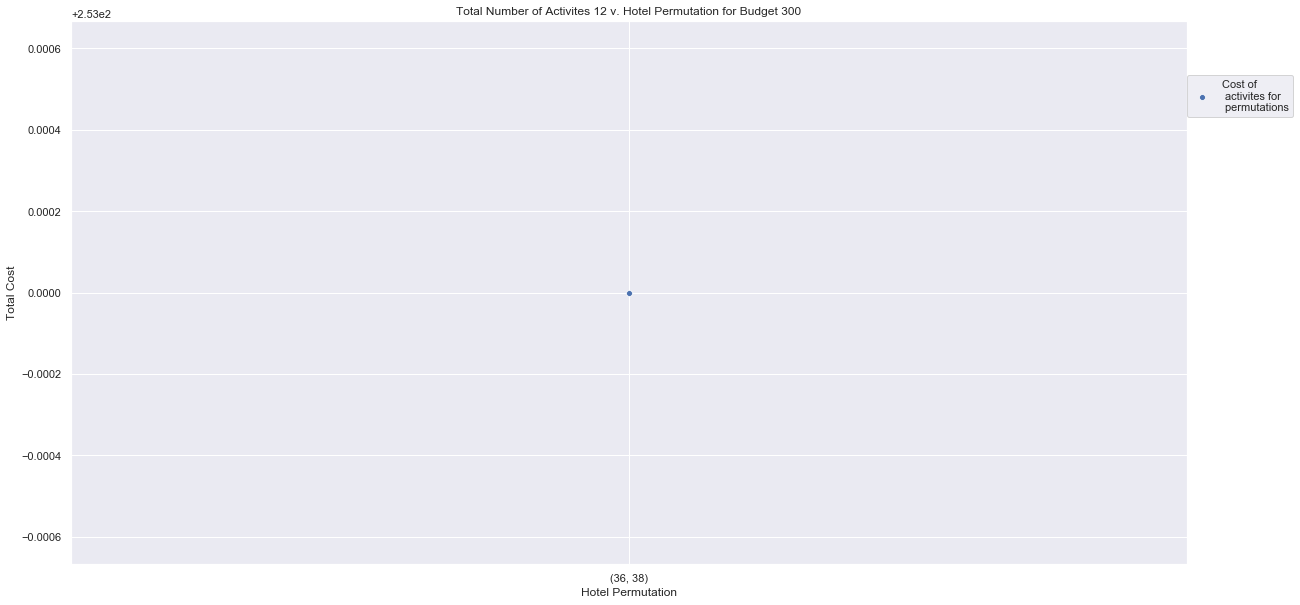

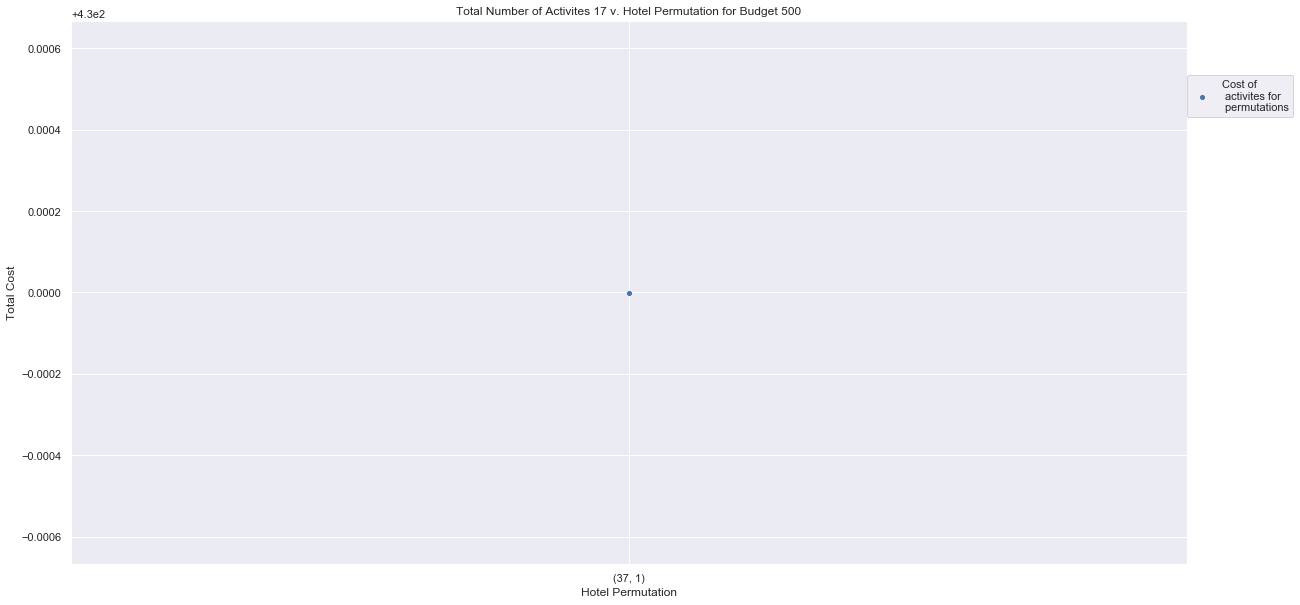

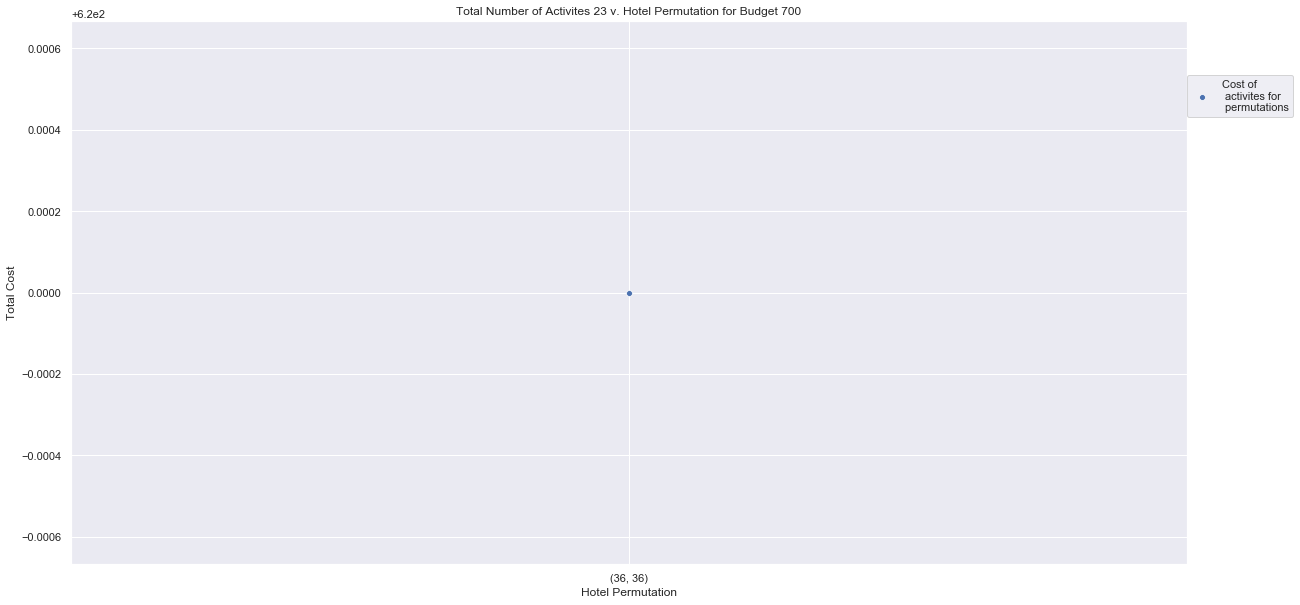

In [48]:
for k,v in bestforEachBudget.items():
    plt.figure(figsize=(20,10))
    totalCost = 0
    totalDiversity = 0
    
    plt.xlabel("Hotel Permutation")
    plt.ylabel("Total Cost", fontsize=12)
    # colormap = plt.cm.gist_ncar
    # plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1.01, 11))))
    costs, permutations = list(), list()
    for m,n in v.items():
        totalactivities = n['Total No of Activities']
        costs.append(n['Total Cost'])
        permutations.append(str(m))
    plt.title(f"Total Number of Activites {totalactivities} v. Hotel Permutation for Budget {k}")

    
    sns.scatterplot(permutations, costs, label=f"Cost of \n activites for \n permutations")
    
    plt.gca().invert_xaxis()

    plt.legend(bbox_to_anchor=(1, 0.9), loc=2, borderaxespad=0.)

    plt.savefig(f"totalActivitesHotel{k}.png")
        

# The End